In [1]:
!pip install torchaudio -q
!pip install librosa -q
!pip install jiwer -q
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!pip install -U transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.7 MB/s eta 0:00:00


In [3]:
!pip install -U datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.3 MB/s eta 0:00:00


In [ ]:
# it is needed because there is a problem in packages relations
!pip uninstall numpy
!pip uninstall numba
!pip install numba

In [1]:
import re
import os
import random
import json
import seaborn as sns
import numpy as np
import pandas as pd
import librosa
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from datasets import load_dataset, load_metric, Audio
from huggingface_hub import hf_hub_download
from datasets import concatenate_datasets
from matplotlib import style
from sklearn.cluster import *
from scipy.stats import pearsonr
from sklearn.manifold import TSNE, MDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import (
    Wav2Vec2Processor, 
    Wav2Vec2ForCTC, 
    Wav2Vec2Processor, 
    Wav2Vec2Tokenizer, 
    Wav2Vec2Config, 
    Wav2Vec2FeatureExtractor, 
    Wav2Vec2CTCTokenizer)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Probing code-switching/'

Mounted at /content/drive


## Prepare Data

In [4]:
timit = load_dataset("timit_asr", data_dir=f'{path}timit/data')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/default-4900dffebcb8e48e/0.0.0/43f9448dd5db58e95ee48a277f466481b151f112ea53e27f8173784da9254fb2. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
russian_test = load_dataset('common_voice', 'ru', split='test')

/root/.cache/huggingface/modules/datasets_modules/datasets/common_voice/220833898d6a60c50f621126e51fb22eb2dfe5244392c70dccd8e6e2f055f4bf/common_voice.py:634: FutureWarning: 
            This version of the Common Voice dataset is deprecated.
            You can download the latest one with
            >>> load_dataset("mozilla-foundation/common_voice_11_0", "en")
            
  warnings.warn(


Generating train split:   0%|          | 0/15481 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8007 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7963 [00:00<?, ? examples/s]

Generating other split:   0%|          | 0/10247 [00:00<?, ? examples/s]

Generating validated split:   0%|          | 0/74256 [00:00<?, ? examples/s]

Generating invalidated split:   0%|          | 0/3056 [00:00<?, ? examples/s]

Dataset common_voice downloaded and prepared to /root/.cache/huggingface/datasets/common_voice/ru/6.1.0/220833898d6a60c50f621126e51fb22eb2dfe5244392c70dccd8e6e2f055f4bf. Subsequent calls will reuse this data.


#### 1. Reduce Data for Analysis

In [6]:
random.seed(20)
to_select = []
NUM_DATA = 50
while len(to_select) != NUM_DATA:
    n = random.randint(0, 319)
    if n not in to_select:
        to_select.append(n)
timit['test'] = timit['test'].select(to_select)

to_select_test = []
while len(to_select_test) != NUM_DATA:
    n = random.randint(0, 8007)
    if n not in to_select_test:
        to_select_test.append(n)
russian_test = russian_test.select(to_select_test)

In [7]:
russian_test = russian_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
russian_test = russian_test.rename_column('sentence', 'text')
timit = timit.remove_columns(['dialect_region', 'sentence_type', 'speaker_id', 'id'])

#### 2. Data Preparation

2.1 Clean text from punctuation

In [8]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\']'
def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

russian_test = russian_test.map(remove_special_characters)
timit = timit.map(remove_special_characters)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [9]:
cyr_to_lat = {
    'а': 'a', 'б': 'b', 'в':'v', 'г': 'g', 'д': 'd', 'е': 'e', 
    'ё': 'ё', 'ж': 'ž', 'з': 'z', 'и': 'i', 'й': 'j', 'к': 'k', 'л': 'l', 
    'м': 'm', 'н': 'n', 'о': 'o', 'п': 'p', 'р': 'r', 'с': 's', 'т': 't', 
    'у': 'u', 'ф': 'f', 'х': 'h', 'ц': 'c', 'ч': 'č', 'ш': 'š', 'щ': 'ś', 
    'ъ': 'ʺ', 'ы': 'y', 'ь': 'ʹ', 'э': 'è', 'ю': 'û', 'я': 'â'
}

2.2 Change cyrillic to latin

In [10]:
def change_text(batch):
    new_text = ''
    for letter in batch['text']:
        try:
            new_text += cyr_to_lat[letter]
        except:
            new_text += letter
    batch['text'] = new_text
    return batch

russian_test = russian_test.map(change_text)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

2.3 Change sample rate to 16000 which is the input rate for Wav2Vec model

In [11]:
russian_test = russian_test.cast_column("audio", Audio(sampling_rate=16_000))

## Vector extraction

### Get sound indexes

We use already fine-tuned model to get sounds predictions and their relative positions in the audio representations. It is made to extract necessary sounds from audio.

In [12]:
def speech_file_to_array_fn(batch):
    batch["speech"] = batch['audio']['array']
    return batch

In [13]:
MODEL_ID_RU = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"
processor_ru = Wav2Vec2Processor.from_pretrained(MODEL_ID_RU)
model_ru = Wav2Vec2ForCTC.from_pretrained(MODEL_ID_RU)

test_dataset = russian_test.map(speech_file_to_array_fn)
predicted_ids_ru = []
for audio in test_dataset:
    inputs = processor_ru(audio["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits = model_ru(inputs.input_values, attention_mask=inputs.attention_mask).logits
        predicted_ids_ru.append(torch.argmax(logits, dim=-1)[0])

_file = hf_hub_download(repo_id=MODEL_ID_RU, filename="vocab.json")
with open(_file, 'r') as f:
  vocab_ru = json.loads(f.read())
convenient_vocab_ru = {}
for k, v in vocab_ru.items():
    try:
        convenient_vocab_ru[v] = cyr_to_lat[k]
    except:
        convenient_vocab_ru[v] = k

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [14]:
MODEL_ID_ENG = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
processor_eng = Wav2Vec2Processor.from_pretrained(MODEL_ID_ENG)
model_eng = Wav2Vec2ForCTC.from_pretrained(MODEL_ID_ENG)

test_dataset = timit['test'].map(speech_file_to_array_fn)
predicted_ids_eng_test = []
for audio in test_dataset:
    inputs_test = processor_eng(audio["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits_test = model_eng(inputs_test.input_values, attention_mask=inputs_test.attention_mask).logits
        predicted_ids_eng_test.append(torch.argmax(logits_test, dim=-1)[0])

_file = hf_hub_download(repo_id=MODEL_ID_ENG, filename="vocab.json")
with open(_file, 'r') as f:
  vocab_en = json.loads(f.read())
convenient_vocab_en = {}
for k, v in vocab_en.items():
  convenient_vocab_en[v] = k

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [15]:
import gc
del logits_test
del logits
del processor_eng
del model_eng
del processor_ru
del model_ru
del inputs
del inputs_test
gc.collect()

71

We process the predictions to extract only necessary vectors. The information about the position of the sound in the list of audiio vector is saved.

In [16]:
def get_sentences_eng(l, rp):
    labels = []
    relative_position = []
    place = []
    needed_sounds = ['d', 't', 'b', 'p', 'g', 'k', 's', 'z', 'f', 'v']
    vowels = ['e', 'u', 'o', 'a']
    for i, letter in enumerate(l):
        if letter in needed_sounds:
            if (i == 0) or (l[i-1] == ' ') or (l[i-1] == '|'):
                labels.append(f'{letter} beginning')
                relative_position.append(rp[i])
            elif i == len(l)-1:
                labels.append(f'{letter} ending')
                relative_position.append(rp[i])
            elif (l[i-1] in vowels) and (l[i+1] in vowels):
                labels.append(f'{letter} between')
                relative_position.append(rp[i])
            elif l[i-1] == 's' and l[i+1] != 'i':
                labels.append(f'{letter} after s')
                relative_position.append(rp[i])
            elif (l[i-1] == letter) and (l[i-2] in vowels) and (l[i+1] in vowels):
                labels.append(f'{letter} between')
                relative_position.append(rp[i])
    return labels, relative_position

def get_sentences_rus(l, rp):
    labels = []
    relative_position = []
    needed_sounds = ['d', 't', 'b', 'p', 'g', 'k', 's', 'z', 'f', 'v']
    vowels = ['a', 'u', 'y', 'o', 'è']
    for i, letter in enumerate(l):
        if letter in needed_sounds:
            if (i == 0) or (l[i-1] == ' ') or (l[i-1] == '|'):
                labels.append(f'{letter} beginning')
                relative_position.append(rp[i])
            elif i == len(l)-1:
                labels.append(f'{letter} ending')
                relative_position.append(rp[i])
            elif (l[i-1] in vowels) and (l[i+1] in vowels):
                labels.append(f'{letter} between')
                relative_position.append(rp[i])
            elif l[i-1] == 's' and (l[i+1] == ' ' or l[i+1] in vowels):
                labels.append(f'{letter} after s')
                relative_position.append(rp[i])
            elif (l[i-1] == letter) and (l[i-2] in vowels) and (l[i+1] in vowels):
                labels.append(f'{letter} between')
                relative_position.append(rp[i])
    return labels, relative_position

def get_relative_position(prediction, conv_vocab):
    all_labels = []
    all_relative_position = []
    for j in range(len(prediction)):
        l = []
        rp = []
        for i, id in enumerate(prediction[j]):
            if id > 5:
                l.append(conv_vocab[int(id)])
                rp.append([float(i), float(i)])
            elif id == 4 and prediction[j][i-1] != 4:
                l.append(conv_vocab[int(id)])
                rp.append([float(i), float(i)])
        all_labels.append(l)
        all_relative_position.append(rp)

    return all_labels, all_relative_position

In [17]:
all_labels_en, all_relative_position_en = get_relative_position(predicted_ids_eng_test, convenient_vocab_en)
all_labels_ru, all_relative_position_ru = get_relative_position(predicted_ids_ru, convenient_vocab_ru)

In [18]:
labels_ru, relative_position_ru = [], []
labels_en, relative_position_en = [], []

for l, rp in zip(all_labels_en, all_relative_position_en):
    labels, relative_position = get_sentences_eng(l, rp)
    labels_en.append(labels)
    relative_position_en.append(relative_position)

for l, rp in zip(all_labels_ru, all_relative_position_ru):
    labels, relative_position = get_sentences_rus(l, rp)
    labels_ru.append(labels)
    relative_position_ru.append(relative_position)

In [19]:
russian_test = russian_test.add_column('relative_positions', relative_position_ru)
russian_test = russian_test.add_column('utterances', labels_ru)
russian_test = russian_test.add_column('all_relative_positions', all_relative_position_ru)
russian_test = russian_test.add_column('all_utterances', all_labels_ru)

timit['test'] = timit['test'].add_column('relative_positions', relative_position_en)
timit['test'] = timit['test'].add_column('utterances', labels_en)
timit['test'] = timit['test'].add_column('all_relative_positions', all_relative_position_en)
timit['test'] = timit['test'].add_column('all_utterances', all_labels_en)

timit['test'] = timit['test'].remove_columns(['file', 'phonetic_detail', 'word_detail'])
russian_test = russian_test.remove_columns(['path'])

russian_test = russian_test.add_column('lang', ['ru']*len(russian_test))
timit['test'] = timit['test'].add_column('lang', ['en']*len(timit['test']))

test = concatenate_datasets([timit['test'], russian_test])

Extraction of vectors from all model states: checkpoints. Each checkpoint is a model state after one epoch of training.

### Baseline

In [20]:
hidden_states = {epoch: [[] for _ in range(len(test))] for epoch in range(19)}

In [ ]:
path = '/content/drive/MyDrive/Probing code-switching/'
tokenizer = Wav2Vec2CTCTokenizer(vocab_file=f"{path}vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1, 
    sampling_rate=16000, 
    padding_value=0.0, 
    do_normalize=True, 
    return_attention_mask=False
)
baseline_proc = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

BASELINE_ID = "facebook/wav2vec2-base"
config = Wav2Vec2Config.from_pretrained(
    BASELINE_ID,
    output_hidden_states=True,
    pad_token_id=baseline_proc.tokenizer.pad_token_id,
    vocab_size=len(baseline_proc.tokenizer)
)

baseline_model = Wav2Vec2ForCTC.from_pretrained(BASELINE_ID, config=config)
test_dataset = test.map(speech_file_to_array_fn)
epoch = 0

for i, audio in enumerate(test_dataset):
    inputs = baseline_proc(audio["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)
    with torch.no_grad():
        vectors = baseline_model(inputs.input_values)

        for layer in c.hidden_states:
            for _, vector in enumerate(layer):
                detach_vector = vector.detach().numpy()
                hidden_states[epoch][i].append([detach_vector])
        
        for _, vector in enumerate(vectors.logits):
            detach_vector = vector.detach().numpy()
            hidden_states[epoch][i].append([detach_vector])

### Checkpoints

In [22]:
path = '/content/drive/MyDrive/Probing code-switching/model/'
checkpoints = os.listdir(path)
checkpoints = [(c, int(c.split('-')[-1])) for c in checkpoints]
checkpoints = sorted(checkpoints, key=lambda x: x[1])
checkpoints = [c[0] for c in checkpoints]

In [ ]:
test_dataset = test.map(speech_file_to_array_fn)    
for epoch, checkpoint in enumerate(checkpoints):
    print(epoch)
    MODEL_ID = path + checkpoint
    processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
    model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

    for i, audio in enumerate(test_dataset):
        with torch.no_grad():
            inputs = processor(audio['speech'], sampling_rate=16_000, return_tensors="pt", padding=True)
            vectors = model(**inputs)

        for layer in vectors.hidden_states:
            for _, vector in enumerate(layer):
                detach_vector = vector.detach().numpy()
                hidden_states[epoch+1][i].append([detach_vector])
        
        for _, vector in enumerate(vectors.logits):
            detach_vector = vector.detach().numpy()
            hidden_states[epoch+1][i].append([detach_vector])

In [24]:
NUM_EPOCHS = list(hidden_states.keys())

## Analysis

### Vectors

In [26]:
def get_vectors(dataset, hidden_states, how='all'):
    '''
    Average vector for each sound in an audio for each layer and epoch.
    Average vector is computed when the model predicts several segments in a row
    with the same label.
    '''
    layers = len(hidden_states[1][0])
    sims_sounds_ru = {i:{} for i in range(layers)}
    sims_sounds_en = {i:{} for i in range(layers)}
    if how=='all':
        REL_POS = 'all_relative_positions'
        UTTER = 'all_utterances'
    elif how=='test':
        REL_POS = 'relative_positions'
        UTTER = 'utterances'
    for dim in tqdm(range(len(dataset))):
        rel_pos = dataset[REL_POS][dim]
        labels = dataset[UTTER][dim]
        if dataset['lang'][dim]=='ru':
            for j in range(layers):
                for i in hidden_states.keys():
                    for k, rp in enumerate(rel_pos):
                        start, stop = int(rp[0]), int(rp[1])
                        avgs = hidden_states[i][dim][j][0][start:stop+1].mean(axis=0)
                        if labels[k] not in sims_sounds_ru[j]:
                            # a list of vectors for each sound 
                            # at each epoch of training
                            sims_sounds_ru[j][labels[k]] = {m:[] for m in hidden_states.keys()}
                        sims_sounds_ru[j][labels[k]][i].append(avgs)
        else:
            for j in range(layers):
                for i in hidden_states.keys(): 
                    for k, rp in enumerate(rel_pos):
                        start, stop = int(rp[0]), int(rp[1])
                        avgs = hidden_states[i][dim][j][0][start:stop+1].mean(axis=0)
                        if labels[k] not in sims_sounds_en[j]:
                            # a list of vectors for each sound 
                            # at each epoch of training
                            sims_sounds_en[j][labels[k]] = {m:[] for m in hidden_states.keys()}
                        sims_sounds_en[j][labels[k]][i].append(avgs)
    return sims_sounds_ru, sims_sounds_en

In [27]:
sims_ru_all, sims_en_all = get_vectors(test, hidden_states, how='all') 
sims_sounds_ru, sims_sounds_en = get_vectors(test, hidden_states, how='test') 

100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


### ReStA

The method allows to measure the similarity between the representations obtained from the model after different epochs.

In [28]:
def get_pearson(
    layers: list, epochs: list, sounds: list, 
    vectors: list, lang: str = 'ru', 
    sounds2: list = None, vectors2: list = None,
    matrix_idx: int = -1):
    '''
    Compute matrices at each layer and epoch and calculate Pearson 
    correlation between the matrices of first and last epoch of one layer
    Output: list of Pearson correlation values
    '''
    pearsons = []
    for layer in layers:
        # the matrices of cosine similarity between the sounds 
        # of one layer at each epoch
        matrices = []
        for epoch in epochs:
            layer_reps = []
            for sound in sounds:
                layer_reps.append(np.mean(vectors[layer][sound][epoch], axis=0))
            if sounds2:
                for sound in sounds2:
                    layer_reps.append(np.mean(vectors2[layer][sound][epoch], axis=0))
            matrix = cosine_similarity(layer_reps)
            flat_matrix = np.triu(matrix, k=1).flatten()
            matrices.append(flat_matrix[flat_matrix!=0])
        pearson_corr = pearsonr(matrices[0], matrices[matrix_idx])
        pearsons.append(pearson_corr.statistic)

    return pearsons

In [52]:
def ReStA(vectors_ru: list, vectors_en: list, matrix_idx: int):
    '''
    Create plot of ReStA and return the values of Pearson correlation
    Output: plt.plot and three lists of Pearson correlation values on 
    Russian data, English data and all data
    '''
    layers = list(vectors_ru.keys())
    sounds_ru = list(vectors_ru[layers[0]].keys())
    sounds_en = list(vectors_en[layers[0]].keys())
    epochs = list(vectors_ru[layers[0]][sounds_ru[0]].keys())
    pearsons = get_pearson(layers, epochs, sounds_ru, vectors_ru, 'all', sounds_en, vectors_en, matrix_idx=matrix_idx)
    pearsons_ru = get_pearson(layers, epochs, sounds_ru, vectors_ru, lang='ru', matrix_idx=matrix_idx)
    pearsons_en = get_pearson(layers, epochs, sounds_en, vectors_en, lang='en', matrix_idx=matrix_idx)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 15), pearsons, marker='o', label='all')
    plt.plot(range(1, 15), pearsons_ru, marker='o', label='ru')
    plt.plot(range(1, 15), pearsons_en, marker='o', label='en')
    plt.ylim(-0.1, 1)
    plt.xlabel('layer')
    plt.ylabel('Pearson correlation coefficient')
    plt.legend()
    plt.title(f'ReStA for each layer between 0 and {epoch} epoch')
    plt.show()

    return pearsons, pearsons_ru, pearsons_en

In [ ]:
pearsons, pearsons_ru, pearsons_en = ReStA(sims_ru_all, sims_en_all, matrix_idx=18)

The ReStA between the representations obtained from the zero epoch and others

100%|██████████| 19/19 [01:56<00:00,  6.14s/it]


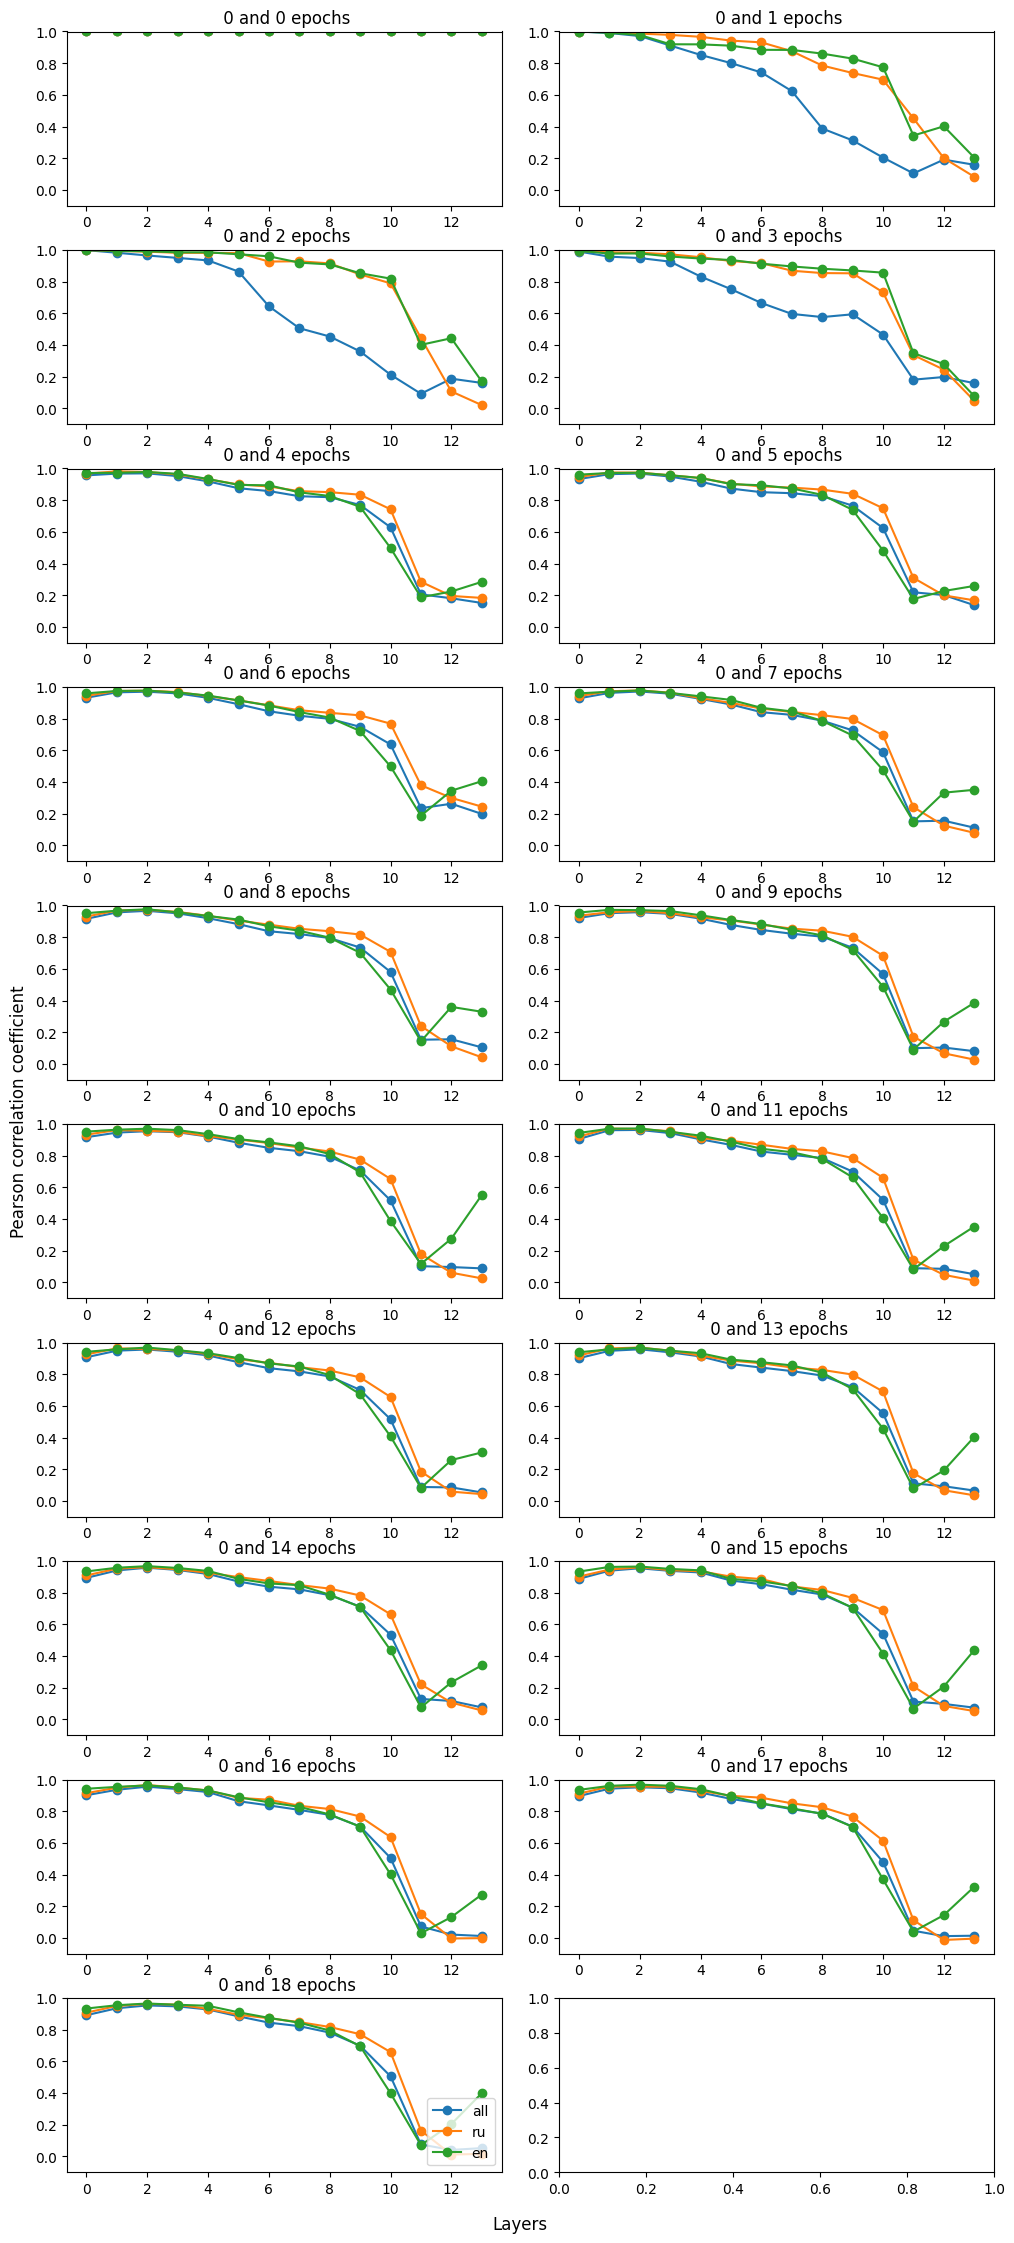

In [31]:
fig, axes = plt.subplots(10, 2, figsize=(10, 22))
fig.tight_layout()
indexes = [(0, 0), (0, 1), (1, 0), (1, 1),
    (2, 0), (2, 1), (3, 0), (3, 1),
    (4, 0), (4, 1), (5, 0), (5, 1),
    (6, 0), (6, 1), (7, 0), (7, 1),
    (8, 0), (8, 1), (9, 0)
    ]
layers = list(sims_ru_all.keys())
for epoch in tqdm(range(19)):
    pearsons, pearsons_ru, pearsons_en = ReStA(sims_ru_all, sims_en_all, matrix_idx=epoch)
    x, y = indexes[epoch][0], indexes[epoch][1]
    axes[x, y].plot(layers, pearsons, marker='o', label='all')
    axes[x, y].plot(layers, pearsons_ru, marker='o', label='ru')
    axes[x, y].plot(layers, pearsons_en, marker='o', label='en')
    axes[x, y].set_ylim(-0.1, 1)
    axes[x, y].set_xlabel('layer')
    axes[x, y].set_ylabel('Pearson correlation coefficient')
    axes[x, y].set_title(f' 0 and {epoch} epochs')

fig.supxlabel('Layers', y=-0.01)
fig.supylabel('Pearson correlation coefficient', x=-0.01)
axes[x, y].legend(loc='lower right')
plt.show()

### Probing

Obtaining all represenations for each layer and epoch

In [31]:
epochs_ru = {i: {j: [] for j in range(14)} for i in hidden_states.keys()}
epochs_en = {i: {j: [] for j in range(14)} for i in hidden_states.keys()}
for layer in sims_ru_all.keys():
    all_sounds_ru = {i:[] for i in sims_ru_all[layer]['d'].keys()}
    all_sounds_en = {i:[] for i in sims_en_all[layer]['d'].keys()}
    for sound in sims_ru_all[layer].keys():
        for epoch in sims_ru_all[layer][sound].keys():
            epochs_ru[epoch][layer].extend(sims_ru_all[layer][sound][epoch])
    for sound in sims_en_all[layer].keys():
        for epoch in sims_en_all[layer][sound].keys():
            epochs_en[epoch][layer].extend(sims_en_all[layer][sound][epoch])

Training logreg for each layer and epoch

In [ ]:
average_acc = []
mistakes = []
for epoch in epochs_ru.keys():
    layers_res = []
    for layer in epochs_ru[epoch].keys():
        all_vectors = epochs_ru[epoch][layer] + epochs_en[epoch][layer]
        all_y = [1]*len(epochs_ru[epoch][layer]) + [0]*len(epochs_en[epoch][layer])
        X_train, X_test, y_train, y_test = train_test_split(all_vectors, all_y, test_size=0.3, random_state=20)
        log_reg = LogisticRegression()
        log_reg.fit(X_train, y_train)
        y_pred = log_reg.predict(X_test)
        layers_res.append(accuracy_score(y_pred, y_test))
    average_acc.append((np.mean(layers_res), min(layers_res), max(layers_res)))

In [ ]:
avgs = [acc[0] for acc in average_acc]
mins = [acc[1] for acc in average_acc]
maxs = [acc[2] for acc in average_acc]
plt.figure(figsize=(10, 5))
plt.plot([i for i in range(19)], avgs, label='average')
plt.plot([i for i in range(19)], mins, label='min')
plt.plot([i for i in range(19)], maxs, label='max')
plt.xlim(-1, 19)
plt.xticks(range(-1, 20, 3), range(-1, 20, 3))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Average, minimum and maximum accuracy\nof language prediction on each epoch')
plt.legend()

### Sounds t-SNE

In [35]:
test_vocab = []
for example in test['utterances']:
    test_vocab.extend(example)
test_vocab = set(test_vocab)

In [46]:
colors = {
 'b beginning': 'black',
 'b between': 'dimgrey',
 'd after s': 'yellowgreen',
 'd beginning': 'green',
 'd between': 'olive',
 'f beginning': 'lightcoral',
 'f between': 'indianred',
 'g beginning': 'firebrick',
 'g between': 'maroon',
 'k after s': 'salmon',
 'k beginning': 'tomato',
 'k between': 'coral',
 'p after s': 'sienna',
 'p beginning': 'chocolate',
 'p between': 'saddlebrown',
 's after s': 'forestgreen',
 's beginning': 'limegreen',
 's between': 'darkgreen',
 't after s': 'royalblue',
 't beginning': 'darkblue',
 't between': 'blue',
 'v beginning': 'blueviolet',
 'v between': 'indigo',
 'z beginning': 'orange',
 'z between': 'darkorange'
}

Preprocessing to create full dataset with necessary sounds to be divided into separate groups by their position in a word ("d" -> "d beginning", "d between") 

In [47]:
for sound in colors.keys():
    try:
        for layer in sims_en_all.keys():
            sims_en_all[layer][sound] = sims_sounds_en[layer][sound]
    except:
        print(sound)
for sound in colors.keys():
    try:
        for layer in sims_ru_all.keys():
            sims_ru_all[layer][sound] = sims_sounds_ru[layer][sound]
    except:
        print(sound)

b between
d after s
k between
z beginning
z between
d after s
f between


In [ ]:
del_sounds_ru = ['d', 'p', 't', 'b', 'k', 'g', 'v', 'f', 'z', 's', '|', 'ʺ']
del_sounds_en = ['d', 'p', 't', 'b', 'k', 'g', 'v', 'f', 'z', 's', '|']
for sound in del_sounds_en:
    for layer in sims_en_all.keys():
        del sims_en_all[layer][sound]
for sound in del_sounds_ru:
    for layer in sims_ru_all.keys():
        del sims_ru_all[layer][sound]
gc.collect()

In [40]:
def get_all_sounds(
        sounds_en: dict=sims_sounds_en, 
        sounds_ru: dict=sims_sounds_ru,
        num_epochs: list=NUM_EPOCHS,
        layer: int=1):
    '''
    The sounds for a given layer at each epoch of fine-tuning
    Output: dictionary
    '''
    all_sounds = {i: {} for i in num_epochs}
    for sound in sounds_en[1].keys():
        try:
            for epoch in num_epochs:
                en_sounds = sounds_en[layer][sound][epoch]
                ru_sounds = sounds_ru[layer][sound][epoch]
                all_sounds[epoch][sound] = {}
                all_sounds[epoch][sound]['sounds'] = en_sounds + ru_sounds
                all_sounds[epoch][sound]['lang'] = ['en']*len(en_sounds) + ['ru']*len(ru_sounds)
        except:
            pass 

    return all_sounds

def get_scatter_sounds(
        all_sounds: dict,
        epoch_to_draw: int=1,
        layer: int=1,
        unique_sounds: set=test_vocab):
    '''
    Draws a T-SNE plot of sounds from the unique_sounds set
    Output: plt.plot()
    '''
    all_vectors = []
    target_sound = []
    target_lang = []
    for sound, vectors in all_sounds[epoch_to_draw].items():
        all_vectors.extend(vectors['sounds'])
        target_sound.extend([sound]*len(vectors['sounds']))
        target_lang.extend(vectors['lang'])
    
    # dimension reduction
    X_embedded = TSNE(n_components=2, perplexity=30, verbose=2, random_state=8).fit_transform(np.array(all_vectors))
    df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'sounds' : target_sound, 'lang': target_lang})
    # scatter plot for each sound in the unique_sounds set
    plt.figure(figsize=(15,10))
    for i, s in enumerate(unique_sounds):
        try:
            plt.scatter(
                df[(df['lang']=='ru') & (df['sounds']==s)]['X'], 
                df[(df['lang']=='ru') & (df['sounds']==s)]['Y'], 
                c=colors[s], 
                label=df[(df['lang']=='ru') & (df['sounds']==s)]['sounds'].tolist()[0]
            )
        except:
            pass
        try:
            plt.scatter(
                df[(df['lang']=='en') & (df['sounds']==s)]['X'], 
                df[(df['lang']=='en') & (df['sounds']==s)]['Y'], 
                c=colors[s], 
                label=df[(df['lang']=='en') & (df['sounds']==s)]['sounds'].tolist()[0],
                marker='x'
            )
        except:
            pass
    plt.title(f'En and Ru sounds on layer {layer}, epoch {epoch_to_draw}', fontsize=20)
    plt.legend()

посчитать среднее расстояние между всеми парами векторов?

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4140 samples in 0.002s...
[t-SNE] Computed neighbors for 4140 samples in 0.640s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4140
[t-SNE] Computed conditional probabilities for sample 2000 / 4140
[t-SNE] Computed conditional probabilities for sample 3000 / 4140
[t-SNE] Computed conditional probabilities for sample 4000 / 4140
[t-SNE] Computed conditional probabilities for sample 4140 / 4140
[t-SNE] Mean sigma: 2.793907
[t-SNE] Computed conditional probabilities in 0.126s
[t-SNE] Iteration 50: error = 86.5655975, gradient norm = 0.0008816 (50 iterations in 1.292s)
[t-SNE] Iteration 100: error = 85.7366867, gradient norm = 0.0004026 (50 iterations in 0.912s)
[t-SNE] Iteration 150: error = 85.7156219, gradient norm = 0.0000293 (50 iterations in 1.153s)
[t-SNE] Iteration 200: error = 85.7156372, gradient norm = 0.0000264 (50 iterations in 0.799s)
[t-SNE] Iteration 250: error = 85.7156372, gradient norm = 0.0000253

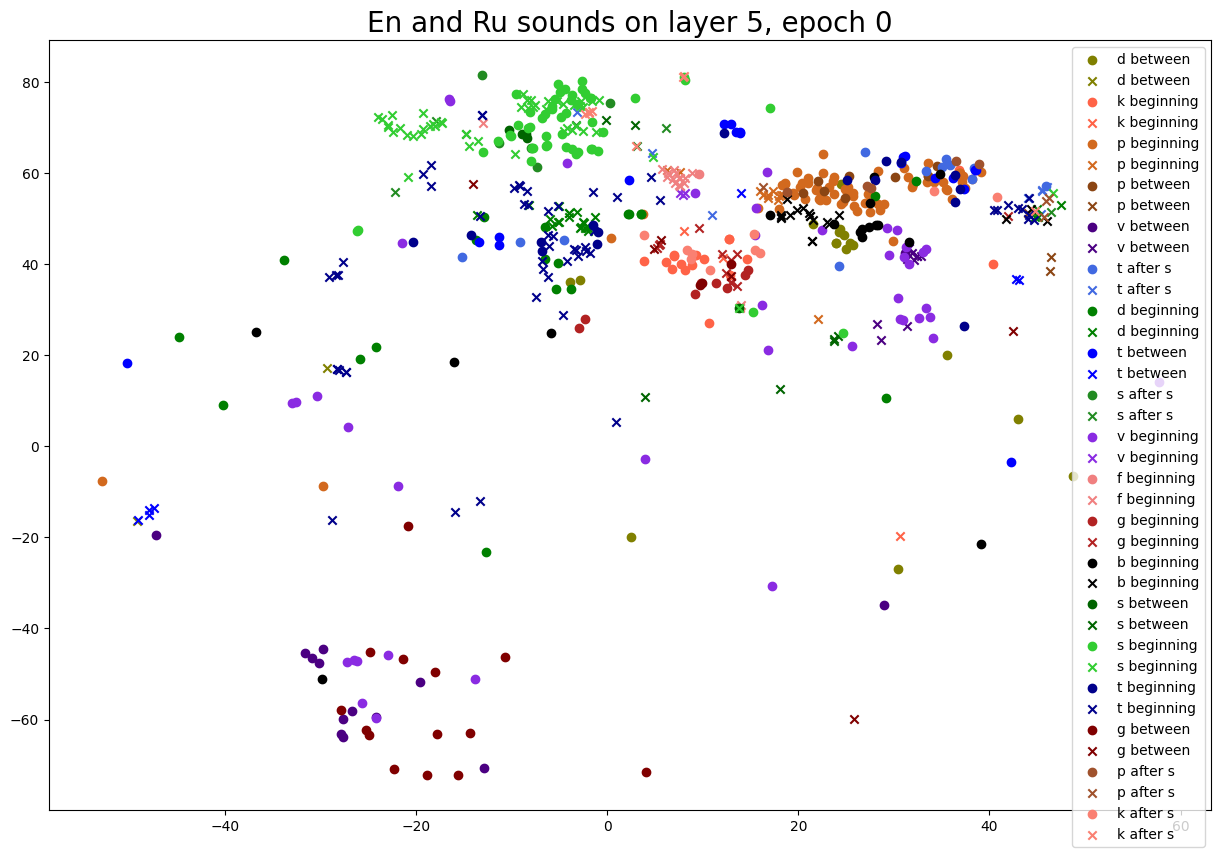

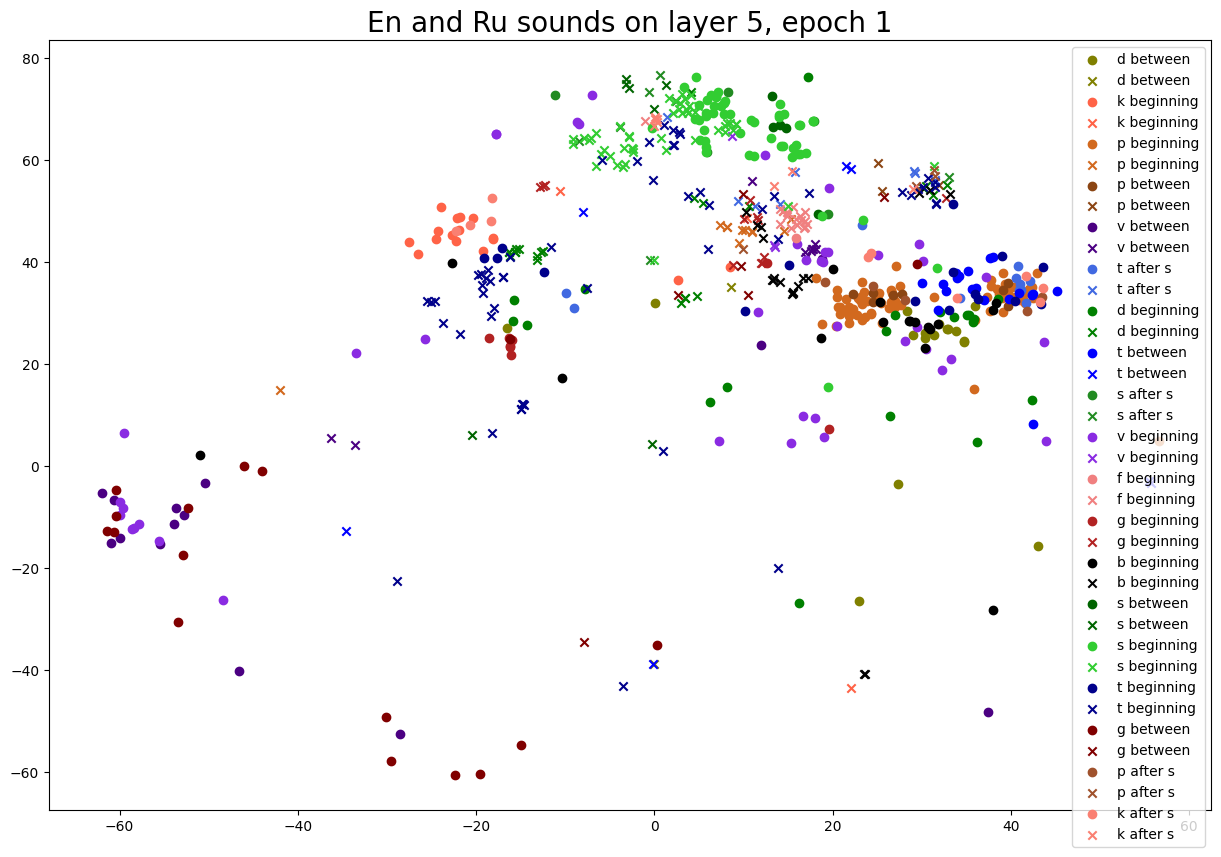

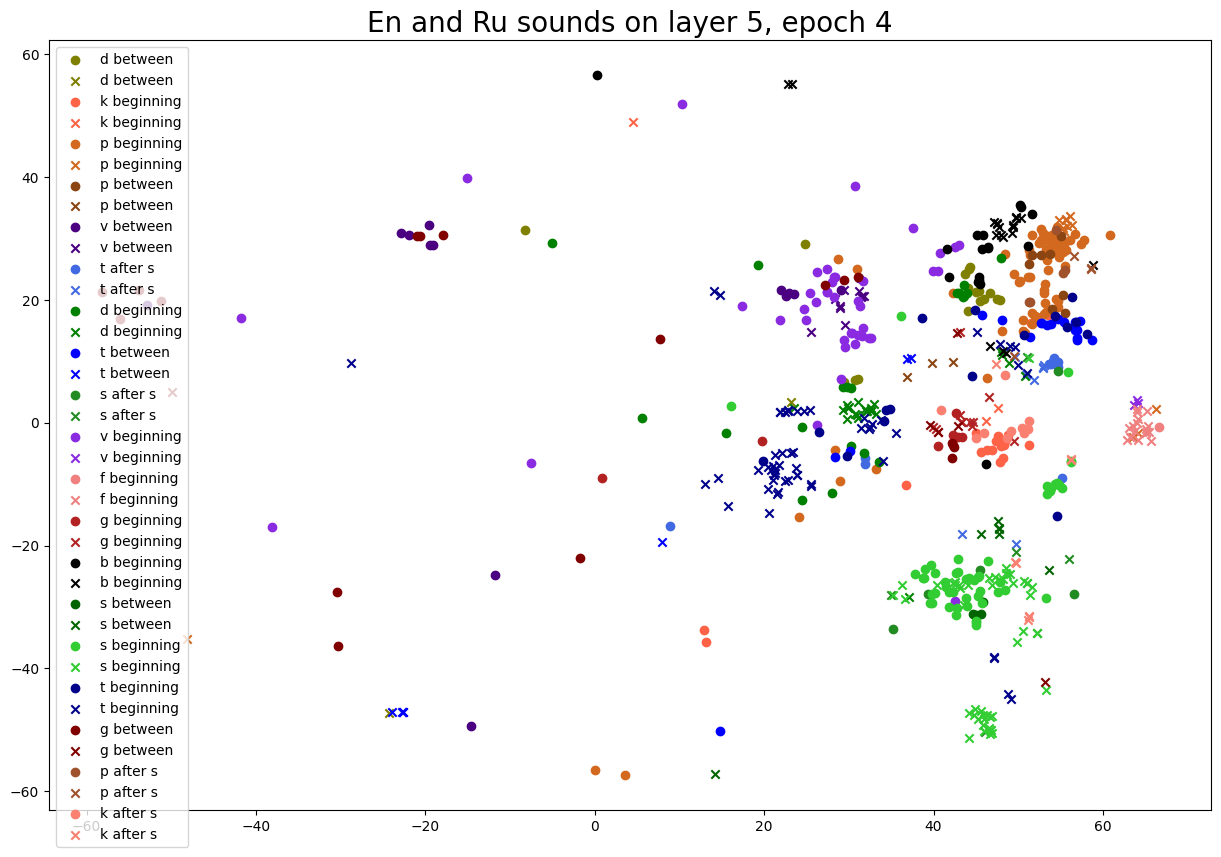

In [42]:
layer = 4
all_sounds = get_all_sounds(sims_en_all, sims_ru_all, layer=layer)
for epoch in [0, 1, 4]:
    get_scatter_sounds(
        all_sounds=all_sounds, 
        epoch_to_draw=epoch, 
        layer=layer+1, 
        unique_sounds=test_vocab
)

### Clusters movements

Next two cells draw a graph with distances between given pairs of sounds.

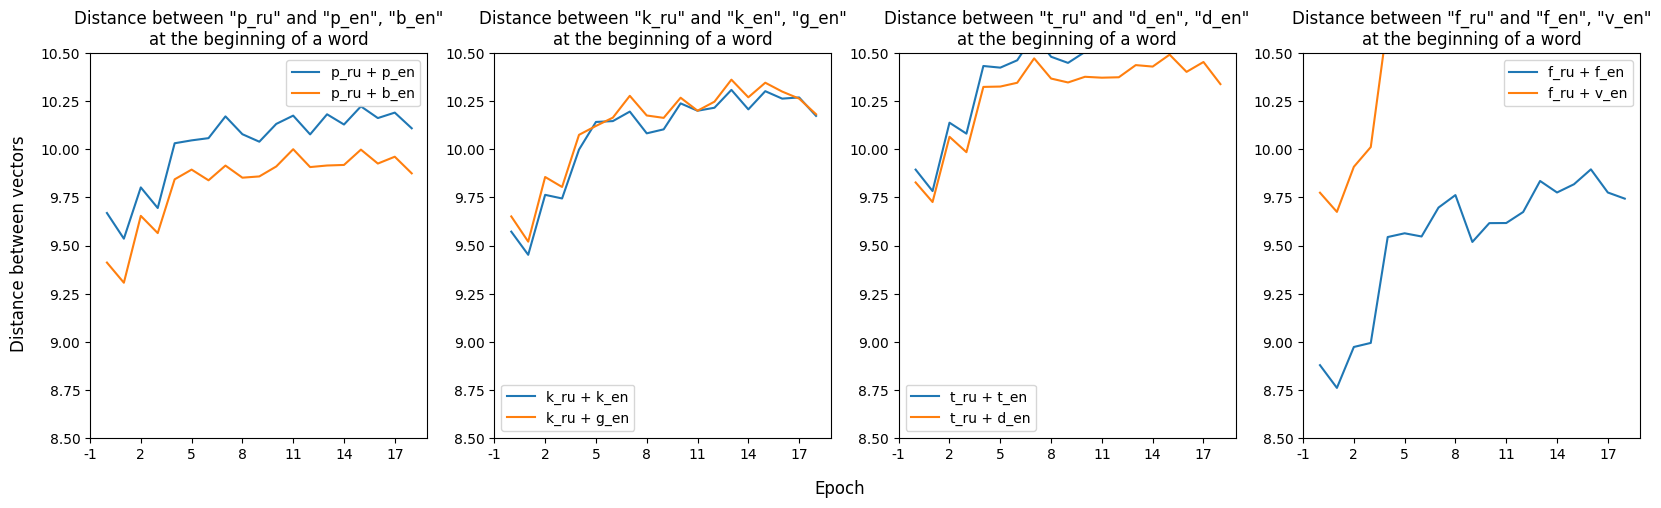

<Figure size 640x480 with 0 Axes>

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
layer = 1
layer_res_p = []
layer_res_b = []
for epoch in NUM_EPOCHS:
    p_sims = 0
    p_num = 0
    for ru_p in (sims_sounds_ru[layer]['p beginning'][epoch] + sims_sounds_ru[layer]['p between'][epoch]):
        for en_p in sims_sounds_en[layer]['p beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_p)
            p_sims += sim
            p_num +=1
    layer_res_p.append(p_sims/p_num)
    b_sims = 0
    b_num = 0
    for ru_p in (sims_sounds_ru[layer]['p beginning'][epoch] + sims_sounds_ru[layer]['p between'][epoch]):
        for en_b in sims_sounds_en[layer]['b beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_b)
            b_sims += sim
            b_num +=1
    layer_res_b.append(b_sims/b_num)

axes[0].plot(range(19), layer_res_p, label='p_ru + p_en')
axes[0].plot(range(19), layer_res_b, label='p_ru + b_en')
axes[0].set_title(f'Distance between "p_ru" and "p_en", "b_en"\nat the beginning of a word')
axes[0].set_ylim(8.5, 10.5)
axes[0].set_xticks(range(-1, 20, 3), range(-1, 20, 3))
axes[0].legend()

layer_res_p = []
layer_res_b = []
for epoch in NUM_EPOCHS:
    p_sims = 0
    p_num = 0
    for ru_p in (sims_sounds_ru[layer]['k beginning'][epoch] + sims_sounds_ru[layer]['k between'][epoch]):
        for en_p in sims_sounds_en[layer]['k beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_p)
            p_sims += sim
            p_num +=1
    layer_res_p.append(p_sims/p_num)
    b_sims = 0
    b_num = 0
    for ru_p in (sims_sounds_ru[layer]['k beginning'][epoch] + sims_sounds_ru[layer]['k between'][epoch]):
        for en_b in sims_sounds_en[layer]['g beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_b)
            b_sims += sim
            b_num +=1
    layer_res_b.append(b_sims/b_num)

axes[1].plot(range(19), layer_res_p, label='k_ru + k_en')
axes[1].plot(range(19), layer_res_b, label='k_ru + g_en')
axes[1].set_title(f'Distance between "k_ru" and "k_en", "g_en"\nat the beginning of a word')
axes[1].set_ylim(8.5, 10.5)
axes[1].set_xticks(range(-1, 20, 3), range(-1, 20, 3))
axes[1].legend()

layer_res_p = []
layer_res_b = []
for epoch in NUM_EPOCHS:
    p_sims = 0
    p_num = 0
    for ru_p in (sims_sounds_ru[layer]['t beginning'][epoch] + sims_sounds_ru[layer]['t between'][epoch]):
        for en_p in sims_sounds_en[layer]['t beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_p)
            p_sims += sim
            p_num +=1
    layer_res_p.append(p_sims/p_num)
    b_sims = 0
    b_num = 0
    for ru_p in (sims_sounds_ru[layer]['t beginning'][epoch] + sims_sounds_ru[layer]['t between'][epoch]):
        for en_b in sims_sounds_en[layer]['d beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_b)
            b_sims += sim
            b_num +=1
    layer_res_b.append(b_sims/b_num)

axes[2].plot(range(19), layer_res_p, label='t_ru + t_en')
axes[2].plot(range(19), layer_res_b, label='t_ru + d_en')
axes[2].set_title(f'Distance between "t_ru" and "d_en", "d_en"\nat the beginning of a word')
axes[2].set_ylim(8.5, 10.5)
axes[2].set_xticks(range(-1, 20, 3), range(-1, 20, 3))
axes[2].legend()

layer_res_p = []
layer_res_b = []
for epoch in NUM_EPOCHS:
    p_sims = 0
    p_num = 0
    for ru_p in sims_sounds_ru[layer]['f beginning'][epoch]:
        for en_p in sims_sounds_en[layer]['f beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_p)
            p_sims += sim
            p_num +=1
    layer_res_p.append(p_sims/p_num)
    b_sims = 0
    b_num = 0
    for ru_p in sims_sounds_ru[layer]['f beginning'][epoch]:
        for en_b in sims_sounds_en[layer]['v beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_b)
            b_sims += sim
            b_num +=1
    layer_res_b.append(b_sims/b_num)

axes[3].plot(range(19), layer_res_p, label='f_ru + f_en')
axes[3].plot(range(19), layer_res_b, label='f_ru + v_en')
axes[3].set_title(f'Distance between "f_ru" and "f_en", "v_en"\nat the beginning of a word')
axes[3].set_ylim(8.5, 10.5)
axes[3].set_xticks(range(-1, 20, 3), range(-1, 20, 3))
axes[3].legend()

fig.supxlabel('Epoch', y=-0.01)
fig.supylabel('Distance between vectors', x=0.085)
plt.legend()
plt.show()

plt.savefig('closeness_all.pdf', format='pdf')

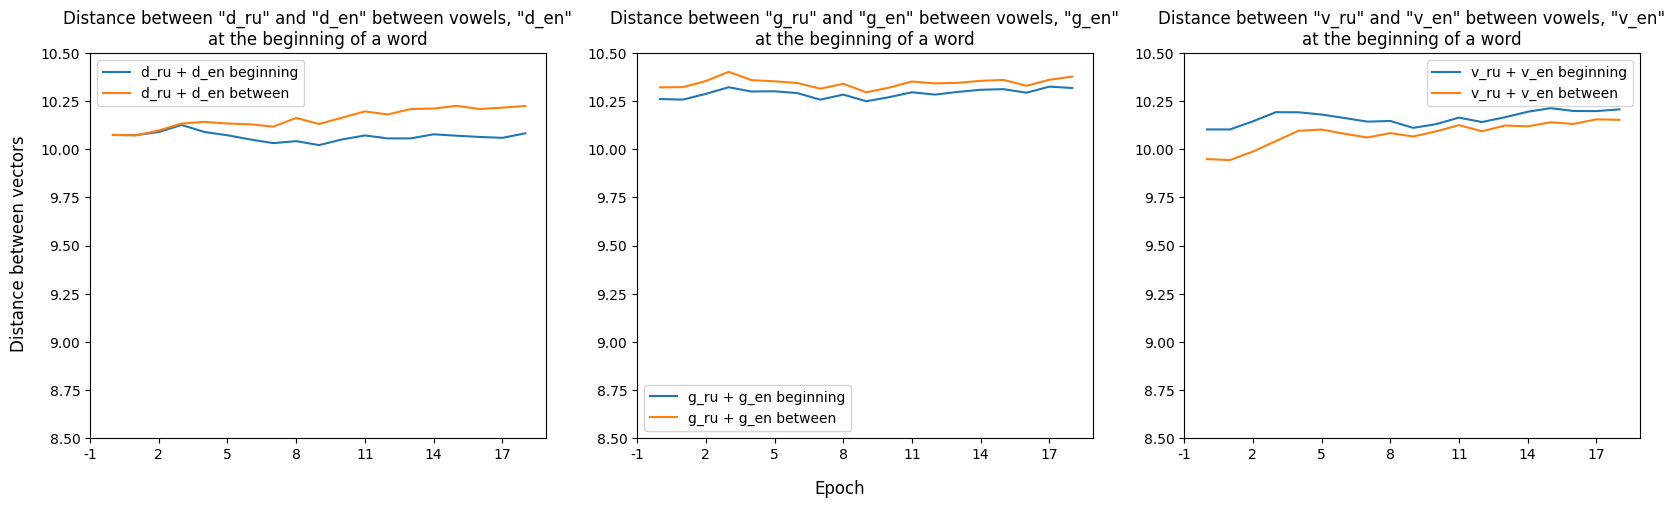

<Figure size 640x480 with 0 Axes>

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
layer = 0
layer_res_p = []
layer_res_b = []
for epoch in NUM_EPOCHS:
    p_sims = 0
    p_num = 0
    for ru_p in (sims_sounds_ru[layer]['d beginning'][epoch] + sims_sounds_ru[layer]['d between'][epoch]):
        for en_p in sims_sounds_en[layer]['d beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_p)
            p_sims += sim
            p_num +=1
    layer_res_p.append(p_sims/p_num)
    b_sims = 0
    b_num = 0
    for ru_p in (sims_sounds_ru[layer]['d beginning'][epoch] + sims_sounds_ru[layer]['d between'][epoch]):
        for en_b in sims_sounds_en[layer]['d between'][epoch]:
            sim = np.linalg.norm(ru_p - en_b)
            b_sims += sim
            b_num +=1
    layer_res_b.append(b_sims/b_num)

axes[0].plot(range(19), layer_res_p, label='d_ru + d_en beginning')
axes[0].plot(range(19), layer_res_b, label='d_ru + d_en between')
axes[0].set_title(f'Distance between "d_ru" and "d_en" between vowels, "d_en"\nat the beginning of a word')
axes[0].set_ylim(8.5, 10.5)
axes[0].set_xticks(range(-1, 20, 3), range(-1, 20, 3))
axes[0].legend()

layer_res_p = []
layer_res_b = []
for epoch in NUM_EPOCHS:
    p_sims = 0
    p_num = 0
    for ru_p in (sims_sounds_ru[layer]['g beginning'][epoch] + sims_sounds_ru[layer]['g between'][epoch]):
        for en_p in sims_sounds_en[layer]['g beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_p)
            p_sims += sim
            p_num +=1
    layer_res_p.append(p_sims/p_num)
    b_sims = 0
    b_num = 0
    for ru_p in (sims_sounds_ru[layer]['g beginning'][epoch] + sims_sounds_ru[layer]['g between'][epoch]):
        for en_b in sims_sounds_en[layer]['g between'][epoch]:
            sim = np.linalg.norm(ru_p - en_b)
            b_sims += sim
            b_num +=1
    layer_res_b.append(b_sims/b_num)

axes[1].plot(range(19), layer_res_p, label='g_ru + g_en beginning')
axes[1].plot(range(19), layer_res_b, label='g_ru + g_en between')
axes[1].set_title(f'Distance between "g_ru" and "g_en" between vowels, "g_en"\nat the beginning of a word')
axes[1].set_ylim(8.5, 10.5)
axes[1].set_xticks(range(-1, 20, 3), range(-1, 20, 3))
axes[1].legend()

layer_res_p = []
layer_res_b = []
for epoch in NUM_EPOCHS:
    p_sims = 0
    p_num = 0
    for ru_p in (sims_sounds_ru[layer]['v beginning'][epoch] + sims_sounds_ru[layer]['v between'][epoch]):
        for en_p in sims_sounds_en[layer]['v beginning'][epoch]:
            sim = np.linalg.norm(ru_p - en_p)
            p_sims += sim
            p_num +=1
    layer_res_p.append(p_sims/p_num)
    b_sims = 0
    b_num = 0
    for ru_p in (sims_sounds_ru[layer]['v beginning'][epoch] + sims_sounds_ru[layer]['v between'][epoch]):
        for en_b in sims_sounds_en[layer]['v between'][epoch]:
            sim = np.linalg.norm(ru_p - en_b)
            b_sims += sim
            b_num +=1
    layer_res_b.append(b_sims/b_num)

axes[2].plot(range(19), layer_res_p, label='v_ru + v_en beginning')
axes[2].plot(range(19), layer_res_b, label='v_ru + v_en between')
axes[2].set_title(f'Distance between "v_ru" and "v_en" between vowels, "v_en"\nat the beginning of a word')
axes[2].set_ylim(8.5, 10.5)
axes[2].set_xticks(range(-1, 20, 3), range(-1, 20, 3))
axes[2].legend()

fig.supxlabel('Epoch', y=-0.01)
fig.supylabel('Distance between vectors', x=0.085)
plt.legend()
plt.show()

plt.savefig('closeness_all.pdf', format='pdf')

In [132]:
def get_centers(sounds_ru: dict, sounds_en: dict, layer: int):
    '''
    Compute centroids of each sound cluster as average vector of a sound
    Output: dicts
    '''
    all_sounds = set(sounds_en[layer].keys()) | set(sounds_ru[layer].keys())
    centers_ru = {i:{} for i in sounds_ru[layer].keys()}
    centers_en = {i:{} for i in sounds_en[layer].keys()}

    for sound in all_sounds:
        for epoch in sounds_ru[layer]['a'].keys(): 
            if sound in sounds_ru[layer].keys():
                ru = [v for v in sounds_ru[layer][sound][epoch]]
                center_ru = np.array(ru).mean(axis=0)
                centers_ru[sound][epoch] = center_ru
            if sound in sounds_en[layer].keys():
                en = [v for v in sounds_en[layer][sound][epoch]]
                center_en = np.array(en).mean(axis=0)
                centers_en[sound][epoch] = center_en

    return centers_ru, centers_en

[t-SNE] Iteration 900: error = 0.2397609, gradient norm = 0.0009207 (50 iterations in 0.406s)
[t-SNE] Iteration 950: error = 0.2394444, gradient norm = 0.0007957 (50 iterations in 0.409s)
[t-SNE] Iteration 1000: error = 0.2391285, gradient norm = 0.0007217 (50 iterations in 0.406s)
[t-SNE] KL divergence after 1000 iterations: 0.239128
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1501 samples in 0.001s...
[t-SNE] Computed neighbors for 1501 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1501
[t-SNE] Computed conditional probabilities for sample 1501 / 1501
[t-SNE] Mean sigma: 1.843634
[t-SNE] Computed conditional probabilities in 0.067s
[t-SNE] Iteration 50: error = 64.7479248, gradient norm = 0.0116593 (50 iterations in 0.542s)
[t-SNE] Iteration 100: error = 62.6460915, gradient norm = 0.0012933 (50 iterations in 0.407s)
[t-SNE] Iteration 150: error = 62.5055389, gradient norm = 0.0002646 (50 iterations in 0.405s)
[t-SNE] Iteration 200: 

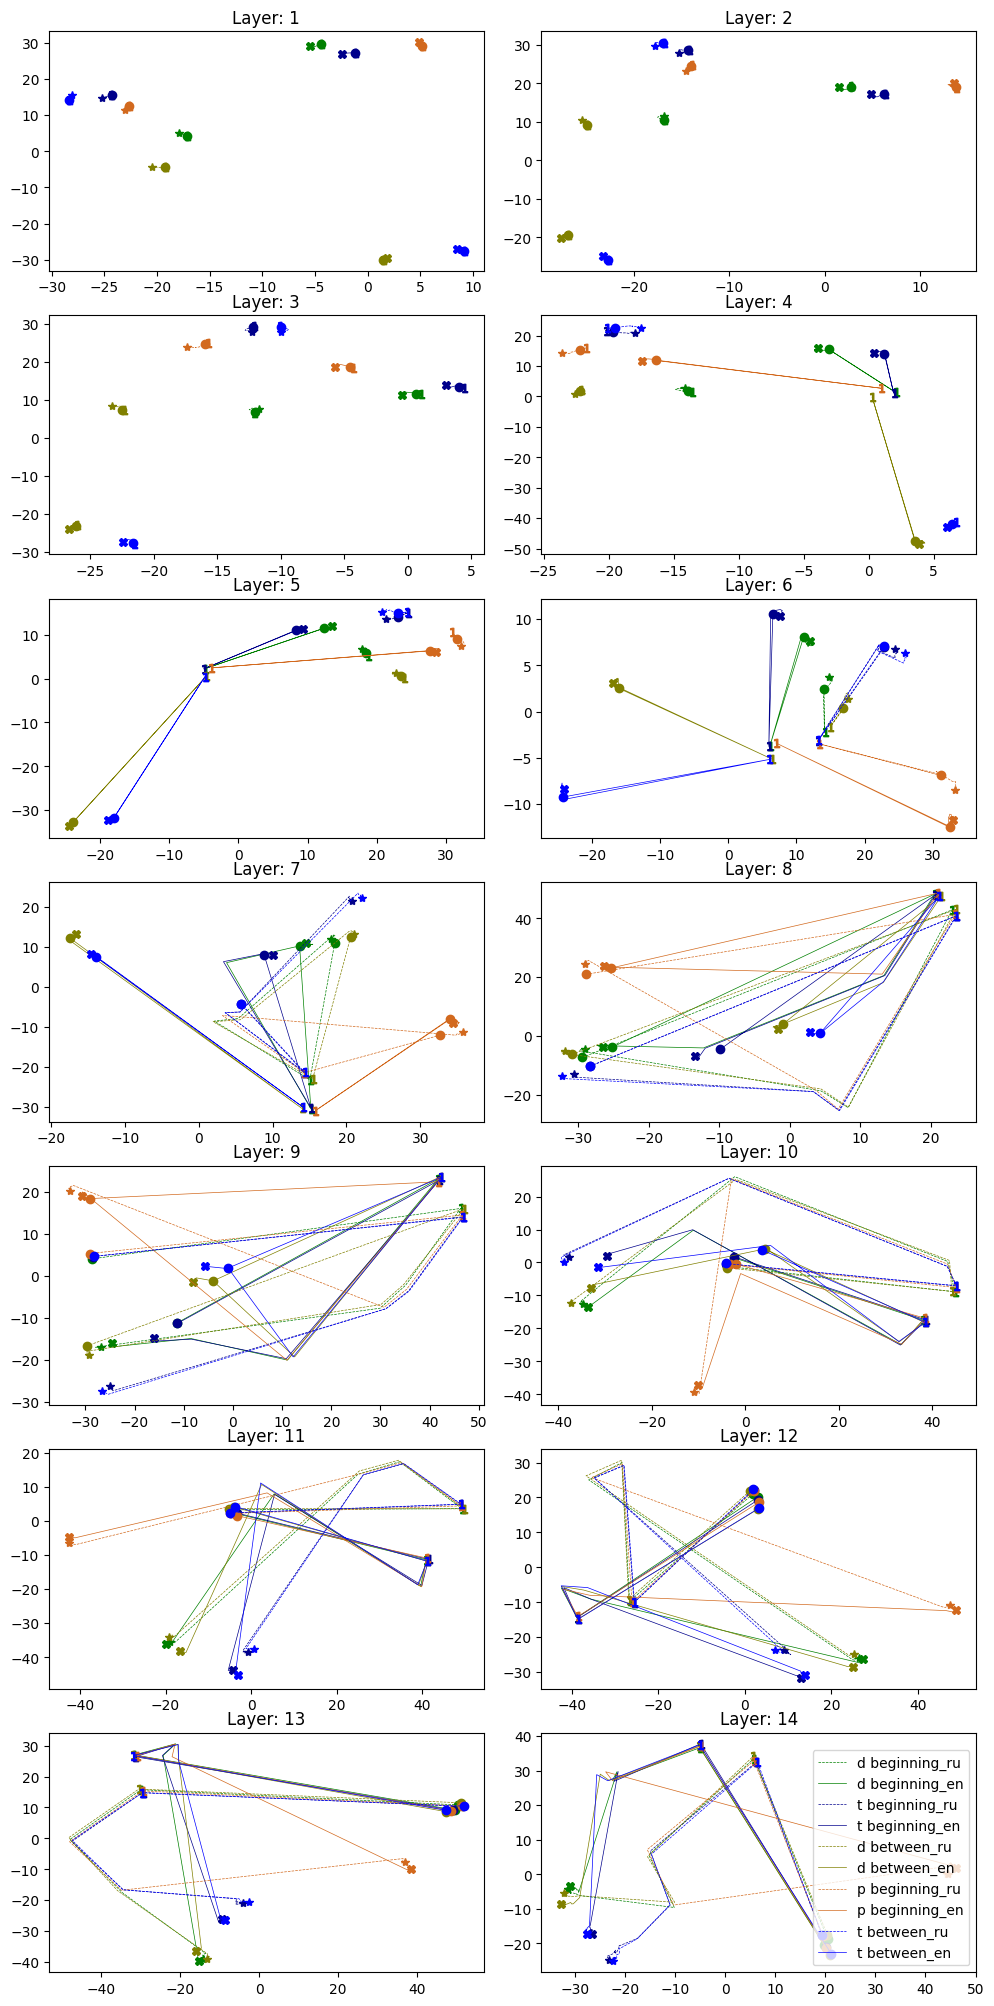

In [141]:
fig, axes = plt.subplots(7, 2, figsize=(10, 20))
fig.tight_layout()
indexes = [(0, 0), (0, 1), (1, 0), (1, 1),
           (2, 0), (2, 1), (3, 0), (3, 1),
           (4, 0), (4, 1), (5, 0), (5, 1),
           (6, 0), (6, 1)
        ]
for layer in range(14):
    centers_ru, centers_en = get_centers(sims_ru_all, sims_en_all, layer=layer)
    tsne = TSNE(n_components=2, perplexity=40, verbose=2)
    my_keys = list(set(centers_ru.keys()) | set(centers_en.keys()) )
    all_values = []
    all_labels = []

    for key in my_keys:
        for epoch in centers_ru['a'].keys():
            if key in centers_ru.keys():
                all_values.append(centers_ru[key][epoch])
                all_labels.append(f'{key}_ru')
            if key in centers_en.keys():
                all_values.append(centers_en[key][epoch])
                all_labels.append(f'{key}_en')

    X_embedded = tsne.fit_transform(np.array(all_values))
    df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'label' : all_labels})
    my_keys =  ['p beginning', 't beginning', 'd beginning', 't between', 'd between']
    x, y = indexes[layer][0], indexes[layer][1]

    for key in df['label'].unique():
        if key[:-3] in my_keys:
            print
            if key.endswith('ru'):
                axes[x, y].plot(df[df['label']==f'{key}']['X'], df[df['label']==f'{key}']['Y'], label=f'{key}', linestyle='--', color=colors[key[:-3]], linewidth=0.5)
                axes[x, y].plot(df[df['label']==f'{key}']['X'].tolist()[0], df[df['label']==f'{key}']['Y'].tolist()[0], marker='o', color=colors[key[:-3]])
                axes[x, y].plot(df[df['label']==f'{key}']['X'].tolist()[1], df[df['label']==f'{key}']['Y'].tolist()[1], marker='$1$', color=colors[key[:-3]])
                axes[x, y].plot(df[df['label']==f'{key}']['X'].tolist()[-1], df[df['label']==f'{key}']['Y'].tolist()[-1], marker='*', color=colors[key[:-3]])
            else:
                axes[x, y].plot(df[df['label']==f'{key}']['X'], df[df['label']==f'{key}']['Y'], label=f'{key}', color=colors[key[:-3]], linewidth=0.5)
                axes[x, y].plot(df[df['label']==f'{key}']['X'].tolist()[0], df[df['label']==f'{key}']['Y'].tolist()[0], marker='o', color=colors[key[:-3]])
                axes[x, y].plot(df[df['label']==f'{key}']['X'].tolist()[1], df[df['label']==f'{key}']['Y'].tolist()[1], marker='$1$', color=colors[key[:-3]])
                axes[x, y].plot(df[df['label']==f'{key}']['X'].tolist()[-1], df[df['label']==f'{key}']['Y'].tolist()[-1], marker='X', color=colors[key[:-3]])
            i += 1
    axes[x, y].set_title(f'Layer: {layer+1}')

plt.legend(loc='lower right')
plt.show()